<span style="color:blue; font: small-caps bold 22px Georgia, serif;">
    Afshin Bozorgpour, Reza Azad, Eman Showkatian and Alaa Sulaiman
</span>
<br>
<span style="color:teal; font: italic small-caps bold 20px/30px Georgia, serif;">
    "Multi-scale Regional Attention Deeplab3+: Multiple Myeloma Plasma Cells Segmentation in Microscopic Images", bmdeep team, rank 2.
</span>
<hr>

# Initialization

install required packages using <code>requirements.txt</code>

In [1]:
!python3 -mpip install pip --upgrade
!python3 -mpip install -r ./requirements.txt

# Importing of packages

## predefined packages

In [2]:
from configparser import ConfigParser
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2, sys
from PIL import Image
from glob import glob
import pickle
from pathlib import Path
import json
import gc


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks

Using TensorFlow backend.


## $$$ packages

In [3]:
import sys 
sys.path.append('./src')

from utilities import (
    resize_pad, sim_resize, resize, show_sbs, clean_nuc_mask,
    crop_multi_scale_submats, do_cyto_pred_process, 
    get_pure_img_bbox, get_cyto_mask, 
    do_cyto_postprocess, get_biggest_cc_msk
)

# Loading the configuration (```conf.json```)

In [4]:
CONFIG_FILE_PATH = "./configs/config.json"

In this section, the required configuration and static variable are loaded.

In [5]:
with open(CONFIG_FILE_PATH, 'r') as fp:
    config = json.load(fp)

Path(config['DATA']['NPY_DIR']).mkdir(parents=True, exist_ok=True)
    
run_name = config['RUN']['name']
imsk_fn = config['RUN']['imsk_folder_name']
final_imsk_fn = config['RUN']['final_imsk_folder_name']

Path('./results').mkdir(parents=True, exist_ok=True)
Path('./results/run_{}'.format(run_name)).mkdir(parents=True, exist_ok=True)
Path('./results/run_{}/{}'.format(run_name, imsk_fn)).mkdir(parents=True, exist_ok=True)
Path('./results/run_{}/{}'.format(run_name, final_imsk_fn)).mkdir(parents=True, exist_ok=True)
Path('./results/run_{}/{}/filtered'.format(run_name, imsk_fn)).mkdir(parents=True, exist_ok=True)

IMSK_DIR   = './results/run_{}/{}/'        .format(run_name, imsk_fn)
F_IMSK_DIR = './results/run_{}/{}/filtered/'.format(run_name, imsk_fn)

CROP_SCALE_LIST = config['RUN']['crop_scale_list']
for sc in CROP_SCALE_LIST+[0,]:
    Path('{}sc_{:1.2f}'.format(  IMSK_DIR, sc)).mkdir(parents=True, exist_ok=True)
    Path('{}sc_{:1.2f}'.format(F_IMSK_DIR, sc)).mkdir(parents=True, exist_ok=True)

# Preparation of input data for the first stage

## Generating $X$ for the first stage

In [6]:
DATA_CFG = config['DATA']

X_path_list = glob('{}*{}'.format(config['DATA']['X_DIR'], config['DATA']['X_FILE_TYPE_EXTENSION']))

X = []
X_org = []
X_names = []
X_shapes = []
for xp in tqdm(X_path_list):
    fn = xp.split('/')[-1].split('.')[0]
    X_names.append(fn)
    
    img = np.array(Image.open(xp))
    X_org.append(img)
    X_shapes.append(img.shape)
    
    img_ = resize(img, tuple(config['NUCS']['MODEL']['input_shape'][:2]), interpolation='linear')
    X.append(img_)
    

X = np.array(X)
np.save(config['DATA']['NPY_DIR']+'X_nuc', X.astype(np.uint8))

100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


# Stage 1) Inference and extract nucleuses

## Loading model

In [7]:
from models.model_nuc import unet_dnspro as NucModel

nuc_model = NucModel(**config['NUCS']['MODEL'])

Instructions for updating:
Colocations handled automatically by placer.


./src/models/model_nuc.py:199: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


## Inference

3/3 [==============================] - 6s 2s/step


100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


113


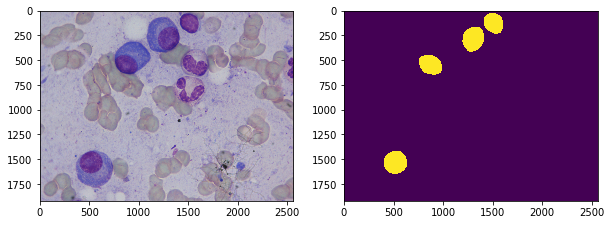

In [8]:
prediction = nuc_model.predict(np.array(X/255.), verbose=1)
prediction = np.squeeze(prediction)

del nuc_model
for i in range(5):
    gc.collect()
    K.clear_session()

nuc_preds = []
for i in tqdm(range(len(prediction))):
    mask = np.where(prediction[i]>config['NUCS']['bth'], 1, 0)
    cleaned_mask = clean_nuc_mask(mask)
    nuc_preds.append(resize((255*cleaned_mask).astype(np.uint8), tuple(X_shapes[i][:2]), 'linear'))
nuc_preds = np.array(nuc_preds)/255.
nuc_pred_masks = np.where(nuc_preds>config['NUCS']['bth'], 255, 0)

print(X_names[0])
show_sbs(X_org[0], nuc_pred_masks[0])

In [9]:
X_org_pp_ch4 = []
for i in tqdm(range(len(X_org))):
    x, nm = X_org[i], nuc_pred_masks[i]
    for ch in range(3):
        x[:,:,i] = cv2.equalizeHist(np.uint8(x[:,:,ch]))
    x = np.concatenate([x, np.expand_dims(nm, -1)], -1)        
    X_org_pp_ch4.append(x)
    
X = np.array(X_org_pp_ch4)
M = np.array(nuc_pred_masks)

print(X.shape, M.shape)

100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


(3, 1920, 2560, 4) (3, 1920, 2560)


# Stage 2)

In [10]:
scales_cropped_data = []
for scale in CROP_SCALE_LIST:
    scale_cropped_data = []
    for i in tqdm(range(len(X_names)), desc='Scale:{:2.2f}'.format(scale)):
        mask, image, name = nuc_pred_masks[i], X[i], X_names[i]
        cropped_nucs_data = crop_multi_scale_submats(image, name, mask, [scale])
        scale_cropped_data.append(cropped_nucs_data)
    scales_cropped_data.append(scale_cropped_data)

Scale:3.00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Visualizing a sample of candidate instances

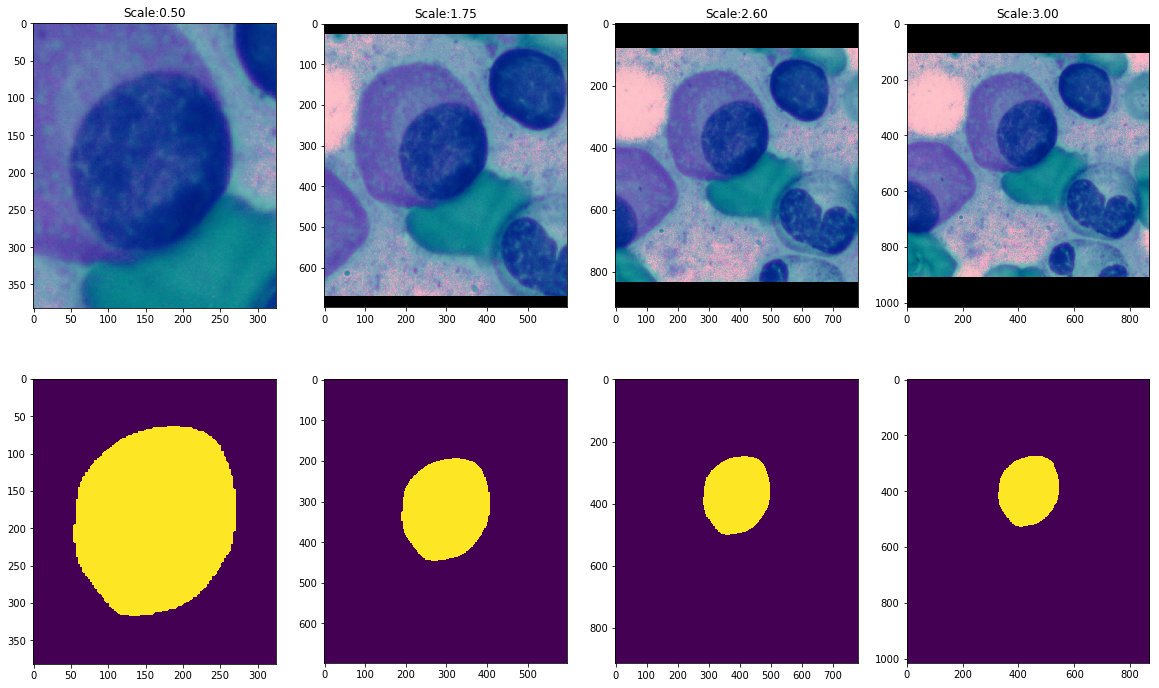

In [11]:
_, axs = plt.subplots(2, len(scales_cropped_data), figsize=(len(scales_cropped_data)*5, 12))
for i, scale_cropped_data in enumerate(scales_cropped_data):
    tmp = 1
    simg = scale_cropped_data[0]['data'][tmp][0]['simg']
    snmsk = scale_cropped_data[0]['data'][tmp][0]['snmsk']
    axs[0, i].imshow(simg[:,:,:3])
    axs[0, i].set_title('Scale:{:1.2f}'.format(CROP_SCALE_LIST[i]))
    axs[1, i].imshow(snmsk)
plt.show()

## Inference the cytoplasm for each extracted nucleus

### Loading model

In [12]:
from models.model_cyt import Deeplabv3pa as CytModel


CFG = config['CYTS']['MODELS']
cyts_preds_scales = []
for scale, scale_cropped_data in zip(CROP_SCALE_LIST, scales_cropped_data):
    
    model_conf = {
        'input_shape': CFG['input_shape_micro'] if scale<CFG['micro_macro_sc_th'] else CFG['input_shape_micro'],
        'pretrained_weights': CFG['sc{:1.2f}_weights'.format(scale)]
    }
    model_scale_params = {
        'binary_th': CFG['sc{:1.2f}_bth_ks'.format(scale)][0],
        'KS'       : CFG['sc{:1.2f}_bth_ks'.format(scale)][1]
    }
    cyt_model = CytModel(**model_conf)

    pred_mask_nucs_cyto = []
    for data in tqdm(scale_cropped_data, desc='Scale:{:1.2f}'.format(scale)):
        preds_cyto_on_sub = data    
        for i, ins in enumerate(preds_cyto_on_sub['data']):
            for j, ins_scale in enumerate(ins):
                x = ins_scale['simg']
                x_shape = x.shape

                x = resize_pad(x, tuple(model_conf['input_shape'][:2]))
                x[:,:,3] = np.where(x[:,:,3]>127, 255, 0)
                bbox = get_pure_img_bbox(x)
                
                pred_cyto = cyt_model.predict(np.array([x/255]), batch_size=1, verbose=0)
                pred_cyto = np.squeeze(pred_cyto)
                ppred_cyto = do_cyto_pred_process(pred_cyto)
                mask_cyto = get_cyto_mask(ppred_cyto, model_scale_params['binary_th'])
                mask_cyto_ = do_cyto_postprocess(mask_cyto, model_scale_params['KS'])
                mask_cyto_ = get_biggest_cc_msk(np.uint8(mask_cyto_))
                mask_cyto_ = mask_cyto_[bbox[0]:bbox[1],bbox[2]:bbox[3]]
                preds_cyto_on_sub['data'][i][j]['scmsk'] = mask_cyto_
        pred_mask_nucs_cyto.append(preds_cyto_on_sub)
    
    del cyt_model
    for i in range(5):
        gc.collect()
        K.clear_session()
        
    cyts_preds_scales.append(pred_mask_nucs_cyto)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Scale:3.00: 100%|██████████| 3/3 [00:07<00:00,  3.50s/it]


# Back candidates to orginal image coordinate

In [13]:
for pred_masks_nucs_cyto, scale in zip(cyts_preds_scales, CROP_SCALE_LIST):
    for data in tqdm(pred_masks_nucs_cyto, desc='Scale:{:1.2f}'.format(scale)):
        preds_cyto_on_sub = data
        meta = preds_cyto_on_sub['meta']
        idx = 1
        for i, ins in enumerate(preds_cyto_on_sub['data']):    
            for j, ins_scale in enumerate(ins):
                simg  = ins_scale['simg' ]
                snmsk = ins_scale['snmsk']
                scmsk = ins_scale['scmsk']
                bbox  = ins_scale['bbox' ]
                pure_bbox = get_pure_img_bbox(simg)
                b = pure_bbox
                try:
                    pure_simg  = simg [b[0]:b[1], b[2]:b[3]]
                    pure_snmsk = snmsk[b[0]:b[1], b[2]:b[3]]
                    pure_scmsk = sim_resize(scmsk, (bbox[2]-bbox[0], bbox[3]-bbox[1]))
                    pure_smsk  = np.where((pure_snmsk>0)|(pure_scmsk>0), 20, 0) 
                    pure_smsk  = pure_smsk + np.where(pure_snmsk>0, 20, 0)
                    idxs, idys = np.where(pure_snmsk>0)
                    pure_smsk[idxs[0], idys[0]] = 20
                except:
                    print(meta['image_name'], idx)
                    continue
                for u in np.unique(pure_smsk):
                    if u not in [0, 20, 40]:
                        print('Ops... image:', meta['image_name'], 'unique:', np.unique(pure_smsk))
                fmask = np.zeros(meta['image_size'][:2], dtype=np.uint8)
                fmask[bbox[0]:bbox[2], bbox[1]:bbox[3]] = pure_smsk
                fn = '{}sc_{:1.2f}/{}_{}.bmp'.format(IMSK_DIR, scale, meta['image_name'], idx)
                cv2.imwrite(fn, fmask)
                idx+=1

Scale:3.00: 100%|██████████| 3/3 [00:03<00:00,  1.04it/s]


In [14]:
for data in tqdm(pred_masks_nucs_cyto, desc='Scale:{:1.2f}'.format(0.00)):
    preds_cyto_on_sub = data
    
    meta = preds_cyto_on_sub['meta']
    idx = 1

    for i, ins in enumerate(preds_cyto_on_sub['data']):
        for j, ins_scale in enumerate(ins):
            simg  = ins_scale['simg' ]
            snmsk = ins_scale['snmsk']
            scmsk = ins_scale['scmsk']
            bbox  = ins_scale['bbox' ]

            pure_bbox = get_pure_img_bbox(simg)
            b = pure_bbox

            pure_simg  = simg [b[0]:b[1], b[2]:b[3]]
            pure_snmsk = snmsk[b[0]:b[1], b[2]:b[3]]

            pure_smsk = np.where(pure_snmsk>0, 40, 0)
            pure_smsk[:,4:] = pure_smsk[:,:-4]
            idxs, idys = np.where(pure_snmsk>0)
            pure_smsk[idxs[0], idys[0]] = 20
            
            for u in np.unique(pure_smsk):
                if u not in [0, 20, 40]:
                    print('Ops... image:', meta['image_name'], 'unique:', np.unique(pure_smsk))

            fmask = np.zeros(meta['image_size'][:2], dtype=np.uint8)
            fmask[bbox[0]:bbox[2], bbox[1]:bbox[3]] = pure_smsk

            fn = '{}sc_{:1.2f}/{}_{}.bmp'.format(IMSK_DIR, 0, meta['image_name'], idx)
            cv2.imwrite(fn, fmask)
            idx+=1

Scale:0.00: 100%|██████████| 3/3 [00:03<00:00,  1.15it/s]


In [15]:
for scale in [0,]+CROP_SCALE_LIST:
    THS = config["FILTERS"]["sc{:1.2f}".format(scale)] if scale > 0 else [0, 200]
    SOURCE_DIR  = '{}sc_{:1.2f}/'.format(  IMSK_DIR, scale)
    REFINED_DIR = '{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale)
    total = 0.
    refined = 0.
    rejected = 0.
    file_path_list = glob(SOURCE_DIR+'*.bmp')
    img_name_list = set([p.split('/')[-1].split('_')[0] for p in file_path_list])
    bar = tqdm(img_name_list, desc='Scale:{:1.2f}'.format(scale))
    for name in bar:    
        imsk_path_list = glob(SOURCE_DIR+name+'_*.bmp')
        idx = 0
        for imp in imsk_path_list:
            total += 1
            imsk = np.asarray(Image.open(imp))
            nuc_area = np.where(imsk==40, 1, 0).sum()
            cyt_area = np.where(imsk==20, 1, 0).sum()
            cyt_to_nuc_ratio = 1.*cyt_area/nuc_area
            if  cyt_to_nuc_ratio > THS[1] or THS[0] > cyt_to_nuc_ratio :
                rejected += 1.
            else:
                idx += 1
                res = Image.fromarray(imsk.astype(np.uint8))
                save_name = '{}{}_{}.bmp'.format(REFINED_DIR, name, idx)
                res.save(save_name)
        bar.set_description('Rejected:{:04.0f}/{:04.0f} ({:2.3f})%'.format(rejected, total, 100.*rejected/total))

Rejected:0015/0024 (62.500)%: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


In [16]:
FILE_TYPE_EXTENSION = '.bmp'
TEST_DATA_X_DIR = config["DATA"]["X_DIR"]
TOTAL_PREDICTION_DIR = './results/run_{}/{}/'.format(run_name, final_imsk_fn)
predictions_list = ['{}sc_{:1.2f}/'.format(F_IMSK_DIR, scale) for scale in CROP_SCALE_LIST]
predictions = []
for prediction_dir in predictions_list:
    predictions += glob('{}*{}'.format(prediction_dir, FILE_TYPE_EXTENSION))
test_x = glob(TEST_DATA_X_DIR + '*' + FILE_TYPE_EXTENSION)
for tfp in tqdm(test_x):
    fn = tfp.split('/')[-1].split(FILE_TYPE_EXTENSION)[0]
    preds = [p for p in predictions if '/'+fn+'_' in p]
    if len(preds):
        cnt = 1
        for pp in preds:
            new_path = TOTAL_PREDICTION_DIR + fn + '_' + str(cnt) + FILE_TYPE_EXTENSION
            os.system("cp {} {}".format(pp, new_path))
            cnt += 1
    else:
        print('There is no prediciton for the file <{}>'.format(fn+FILE_TYPE_EXTENSION))

100%|██████████| 3/3 [00:15<00:00,  4.52s/it]


# Create the submission file

In [17]:
!python3 submission.py -s ./results/run_dns/final_imsk/ -d ./

100%|█████████████████████████████████████████████| 3/3 [00:05<00:00,  1.64s/it]
3
saved: ./submission.txt


In [18]:
!apt-get update
!apt-get install zip
!zip submission.zip submission.txt

Get:1 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  InRelease
Ign:1 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  InRelease
Get:2 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  Release [574 B]
Get:2 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  Release [574 B]    
Ign:3 http://ppa.launchpad.net/jonathonf/python-3.6/ubuntu xenial InRelease    
Hit:5 http://archive.ubuntu.com/ubuntu xenial InRelease                        
Ign:6 http://ppa.launchpad.net/jonathonf/python-3.6/ubuntu xenial Release      
Get:7 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [109 kB]       
Ign:8 http://ppa.launchpad.net/jonathonf/python-3.6/ubuntu xenial/main amd64 Packages.diff/Index
Ign:9 http://ppa.launchpad.net/jonathonf/python-3.6/ubuntu xenial/main all Packages
Get:10 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [107 kB]    
Ign:11 http://ppa.launchpad.net/jonathonf/python-3.6/ubuntu xenial/main amd64 Packages
Get:12 http://security.ubuntu.com/ub